In [71]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 24

@author: yaning
"""

import HH as HH
import importlib
import numpy as np
import matplotlib.pyplot as plt

In [72]:
importlib.reload(HH)

<module 'HH' from '/home/yaning/Documents/Spiking_NN/HH.py'>

In [69]:
# simulation environment
deltaTms = 0.05
Cm = 1
Vm = 0
# 5000 cycles and every cycle is 0.05ms
# in total 250ms
pointCount = 5000
voltages = np.empty(pointCount)
times = np.arange(pointCount) * 0.01
stim = np.zeros(pointCount)
stim[1200:3800] = 20  # create a square pulse

# presynapse firing
tsp_pre = [500,2000,3500]
tsp_post = [550, 2200, 3000]

In [75]:
# gate states for voltage gated channels
# they share the same m,n,h
m = HH.Gate(0,0,0)
n = HH.Gate(0,0,0)
h = HH.Gate(0,0,0)

sodium_channel = HH.Voltage_Sodium(Vm)
potassium_channel = HH.Voltage_Potassium(Vm)
leaky_channel = HH.Voltage_Leak(Vm)

ampa_receptor = HH.LigandGatedChannelFactory.create_AMPA(0, record_lists = [tsp_pre, tsp_post])


# m.init_update(m, n, h, deltaTms)
# n.init_update(m, n, h, deltaTms)

for i in range(len(times)):

    sodium_channel.update_gP(m, n, h, deltaTms)
    potassium_channel.update_gP(m, n, h, deltaTms)

    ampa_receptor.update_gP(i, deltaTms, tsp_pre, tsp_post)

    # get the currents
    INa = sodium_channel.current()
    IK = potassium_channel.current()
    Ileak = leaky_channel.current()
    Iampa = ampa_receptor.current()

    print(f"INa is {INa}")
    print(f"Iampa is {Iampa}")

    # sum the currents
    Isum = stim[i] - INa - IK - Ileak - Iampa
    Vm += deltaTms * Isum / Cm

    voltages[i] = Vm

    # update the voltages for each channel
    sodium_channel.Vm = Vm
    potassium_channel.Vm = Vm
    leaky_channel.Vm = Vm
    ampa_receptor.Vm = Vm




INa is -8.218800319122805e-05
Iampa is -0.0
INa is -0.0036243743490990145
Iampa is 0.06023513062845823
INa is -0.016112729226889617
Iampa is -0.49473021491237174
INa is -0.037603864842314656
Iampa is 4.086869032698188
INa is -0.06474381038861592
Iampa is -29.508671748792885
INa is -0.10262743642398067
Iampa is 431.18983593246446
INa is -0.022834660673690547
Iampa is 17696.104378271328
INa is 1.3617598224461627e+80
Iampa is -6623295.023213177
INa is inf
Iampa is 3.756081377737782e+83
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is nan
Iampa is nan
INa is n

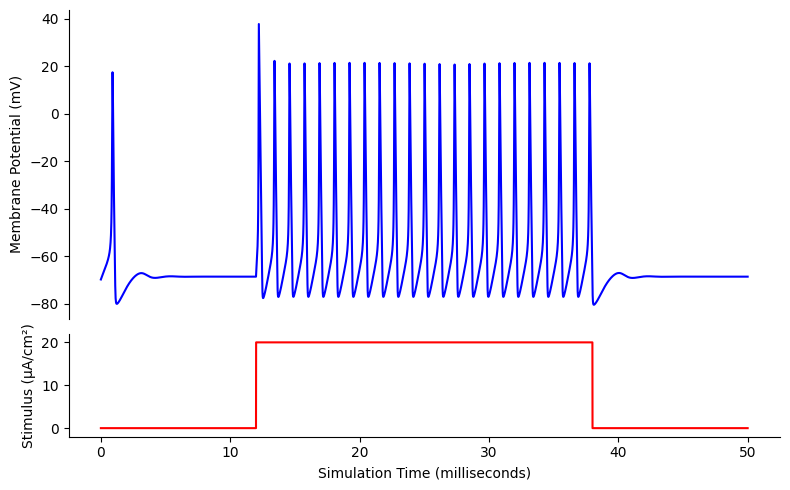

In [74]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(times, voltages - 70, 'b')
ax1.set_ylabel("Membrane Potential (mV)")
# ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontSize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

ax2.plot(times, stim, 'r')
ax2.set_ylabel("Stimulus (µA/cm²)")
ax2.set_xlabel("Simulation Time (milliseconds)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.margins(0, 0.1)
plt.tight_layout()
# plt.savefig("dev/concept4.png")
plt.show()